<a href="https://colab.research.google.com/github/ekotyoo/Racana/blob/Machine_Learning/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from collections import deque
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_squared_error



In [2]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

#Preparing Data Set
memasukan data tempat wisata

In [3]:
place = pd.read_csv('Dataset - tourismBali.csv')
print(place)


    Place_Id                     Place_Name  \
0          1              Agrowisata Satria   
1          2                     Agung Bali   
2          3  Wisata Air Panas Toya Bungkah   
3          4         Air Terjun Aling-Aling   
4          5          Air Terjun Tegenungan   
..       ...                            ...   
70        71         Teras Sawah Tegalalang   
71        72                   Tirta Gangga   
72        73                  Waterbom Bali   
73        74       Alas Harum Agro Tourism    
74        75     Wisata Agro Teba Sari Bali   

                                          Description  Weekend Holiday Price  \
0   Agrowisata Satria menawarkan 'rasa' Bali pada ...                  50000   
1   Dapatkan berbagai produk oleh-oleh khas Bali b...                      0   
2   Pemandian air panas di dekat gunung Batur (Pem...                  70000   
3   Keberadaan air terjun ini semakin mempercantik...                  20000   
4   Bosan dengan wisata alam pantai

Memasukkan data rating

In [4]:
rating = pd.read_csv('Dataset - Rating.csv')
rating.head()

,User_Id,Place_Id,Nama Tempat,Place_Rating
0,1,2,Agung Bali Oleh-Oleh,3
1,1,7,Aloha Ubud Swing,5
2,1,8,Bali Bird Park,5
3,1,12,Big Garden Corner,2
4,1,13,Wanagiri Hidden Hills,5


Filtering data rating

In [5]:
min_place_rating = 10
filter_place = (rating["Place_Id"].value_counts()>min_place_rating)
filter_place = filter_place[filter_place].index.tolist()

min_user_rating = 10
filter_user = (rating["User_Id"].value_counts()>min_user_rating)
filter_user = filter_user[filter_user].index.tolist()

data_filtered = rating[(rating["Place_Id"].isin(filter_place)) & 
                       (rating["User_Id"].isin(filter_place))]
del filter_place,filter_user,min_place_rating,min_user_rating
print('Shape User-Ratings unfiltered:\t{}'.format(rating.shape))
print('Shape User-Ratings filtered:\t{}'.format(data_filtered.shape))

Shape User-Ratings unfiltered:	(3000, 4)
Shape User-Ratings filtered:	(2250, 4)


Membagi data set menjadi train dan test

In [6]:
data_filtered = data_filtered.sample(frac=1).reset_index(drop=True)

n =500

df_train = data_filtered[:-n]
df_test = data_filtered[-n:]

#Deep Learning With Keras
With its embedding layers this is similar to the matrix factorization approach above, but instead of using a fixed dot-product as recommendation we will utilize some dense layers so the network can find better combinations.

In [7]:
# Mapping user dan place id
user_mapping = {id:i for i, id in enumerate(data_filtered['User_Id'].unique())}
place_mapping = {id:i for i, id in enumerate(data_filtered['Place_Id'].unique())}


# Membagi data berdasarkan mapping
train_user = df_train['User_Id'].map(user_mapping)
train_place = df_train['Place_Id'].map(place_mapping)

test_user = df_test['User_Id'].map(user_mapping)
test_place = df_test['Place_Id'].map(place_mapping)

# Atur Variabel
user_embedding_size = 20
place_embedding_size = 10

# Masukin parameter
users = len(user_mapping)
places = len(place_mapping)
embedding_size = 10


Mulai Pembuatan Model

In [8]:


#Mengatur input layer
user_id_input = Input(shape=[1], name='user')
place_id_input = Input(shape=[1], name='place')

# Membuat Embedding layer
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
place_embedding = Embedding(output_dim=place_embedding_size, 
                            input_dim=places,
                            input_length=1, 
                            name='item_embedding')(place_id_input)

# Reshape embedding layers yang sudah dibuat
user_vector = Reshape([user_embedding_size])(user_embedding)
place_vector = Reshape([place_embedding_size])(place_embedding)

# Di concate supaya bisa jadi 1 list
concat = Concatenate()([user_vector, place_vector])

# masukin dense layer
fc1 = Dense(64, activation='relu')(concat)
y = Dense(1)(fc1)



In [9]:
# Setup model yang sudah dibuat
model = Model(inputs=[user_id_input, place_id_input], outputs=y)
model.compile(
    loss = "mse",optimizer ="adam",metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Hasil fit model
history = model.fit([train_user, train_place],
          df_train['Place_Rating'],
          batch_size=256, 
          epochs=100,
          validation_split=0.1,
          shuffle=True)


Epoch 1/100
7/7 [==============================] - 1s 68ms/step - loss: 17.9800 - root_mean_squared_error: 4.2403 - val_loss: 16.9795 - val_root_mean_squared_error: 4.1206
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 17.4273 - root_mean_squared_error: 4.1746 - val_loss: 16.4145 - val_root_mean_squared_error: 4.0515
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 16.7961 - root_mean_squared_error: 4.0983 - val_loss: 15.7201 - val_root_mean_squared_error: 3.9649
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 16.0025 - root_mean_squared_error: 4.0003 - val_loss: 14.8310 - val_root_mean_squared_error: 3.8511
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 14.9861 - root_mean_squared_error: 3.8712 - val_loss: 13.6886 - val_root_mean_squared_error: 3.6998
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 13.6845 - root_mean_squared_error: 3.6993 - val_loss: 12.2580 - val_ro

Mencoba Model 

In [10]:
# model.save('saved_model/my_model')

In [11]:
# Test model
y_pred = model.predict([test_user, test_place])
y_true = df_test['Place_Rating'].values

16/16 [==============================] - 0s 2ms/step


In [12]:
#  Evaluasi dengan RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))



Testing Result With Keras Deep Learning: 0.9385 RMSE


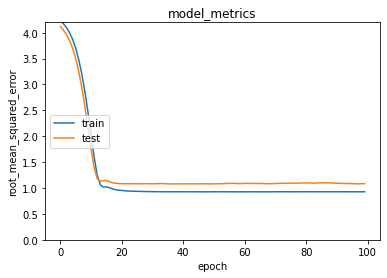

In [13]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=4.2)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Mulai Testing dan Predicting 

In [14]:
# Menyiapkan dataframe
place_df = place[['Place_Id','Place_Name','Category','Rating','Weekend Holiday Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()


In [15]:
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [16]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [17]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [18]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [19]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
 
# Mengubah rating menjadi nilai float
df['Place_Rating'] = df['Place_Rating'].values.astype(np.float32)
 
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Rating']), max(df['Place_Rating'])
 
print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 100, Number of Place: 75, Min Rating: 1.0, Max Rating: 5.0


In [20]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [21]:
class DeepRecommender(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(DeepRecommender, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.places_bias = Embedding(num_places, 1) # layer embedding places bias
    self.dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # memanggil layer embedding 3
    places_bias = self.places_bias(inputs[:, 1]) # memanggil layer embedding 4
    dot_user_places = tf.tensordot(user_vector, places_vector, 2) 
    x = dot_user_places + user_bias + places_bias
    y = self.dense1(x)
    return self.dense2(y)


In [22]:
model1 = DeepRecommender(num_users, num_place, 50) # inisialisasi model
 
# model compile
model1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [52]:
model1.save('path_to_my_model',save_format='tf')

INFO:tensorflow:Assets written to: path_to_my_model\assets


In [53]:
new_model = keras.models.load_model('path_to_my_model')

In [55]:
# Mengambil top rekomendasi
ratings = new_model.predict(user_place_array,50).flatten()
top_ratings_indices = ratings.argsort()[:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
recommended_place_ids = list(recommended_place_ids)
print(recommended_place_ids)

1/1 [==============================] - 0s 109ms/step
[75, 45, 67, 12, 58, 11, 74, 70, 17, 22, 68, 35, 44, 62, 8, 36, 9, 43, 52, 21, 57, 50, 33, 59, 5, 31, 65, 46, 23, 69, 25, 56, 28, 26, 51, 34, 20, 42, 38, 6, 24, 10, 13, 1, 47]


In [ ]:
#Membuat Filter
Place_Upto_100 = place_df[(place_df['price'] >= 100000)]
Place_Upto_100 = list(Place_Upto_100["id"])
print(Place_Upto_100)

[7, 8, 10, 69, 70, 73]


In [ ]:
#Filtering place up to 100k
recom_id_upto_100 = [x for x in recommended_place_ids if x in Place_Upto_100]
print(recom_id_upto_100)

[10, 8, 69]


In [ ]:
#Filtering place up to 100k
recom_id_under_100 = [x for x in recommended_place_ids if x not in Place_Upto_100]
print(recom_id_under_100)

[42, 23, 11, 74, 65, 35, 6, 14, 37, 17, 33, 38, 32, 26, 9, 12, 1, 66, 36, 63, 47, 18, 56, 41, 15, 55, 57, 49, 27, 24, 46, 29, 34, 21, 62, 75, 48, 20, 53, 3, 40, 59]


In [ ]:
print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)
 
top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Rating',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Harga Tiket Masuk ', row.price, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)

Daftar rekomendasi untuk: User 71

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
Air Terjun Tegenungan : Alam
Aloha Ubud Swing  : Agrowisata
Bukit Wanagiri : Alam
Danau Beratan : Alam
Pantai Pasih Uug : Pantai

------------------------------------------------------------
Top 7 place recommendation
------------------------------------------------------------
1 . Agrowisata Satria 
     Agrowisata , Harga Tiket Masuk  50000 , Rating Wisata  3.0 

2 . Wisata Air Panas Toya Bungkah 
     Alam , Harga Tiket Masuk  70000 , Rating Wisata  4.0 

3 . Air Terjun Tukad Cepung 
     Alam , Harga Tiket Masuk  15000 , Rating Wisata  4.5 

4 . Bali Bird Park 
     Cagar Alam , Harga Tiket Masuk  110000 , Rating Wisata  4.5 

5 . Handara Iconic Gate 
     Budaya , Harga Tiket Masuk  20000 , Rating Wisata  3.5 

6 . Bali Swing 
     Rekreasi , Harga Tiket Masuk  500000 , Ratin